# 9. Normative Model Preparation

## Obiettivo
Preparare i dati volumetrici dei soggetti sani (età ≥45) per la creazione di un modello normativo.

## Dataset
- **101 metriche volumetriche** + 8 QC scores

## Pipeline
1. Load and explore data
2. Apply quality control filters
3. Calculate derived metrics (normalized volumes, ratios, asymmetries)
4. Select regions of interest for normative modeling
5. Exploratory data analysis (distributions, correlations, age effects)
6. Prepare final dataset for normative modeling

## 1. Setup and Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Paths
data_dir = Path('../data')
volumes_file = data_dir / 'combined' / 'subjects_with_volumes_age45plus.csv'

In [2]:
# Load data
df = pd.read_csv(volumes_file)
print(f"Loaded {len(df)} subjects")
print(f"Columns: {df.shape[1]}")
print(f"\nDataset distribution:")
print(df['dataset'].value_counts())

Loaded 2405 subjects
Columns: 120

Dataset distribution:
dataset
OASIS3    960
ADNI      519
IXI       430
SRPBS     251
PPMI      160
OASIS2     85
Name: count, dtype: int64


In [3]:
# Separate column types
demo_cols = ['subject_id', 'dataset', 'age', 'sex', 'site', 'field_strength', 'visit_code', 'exam_date']
vol_cols = [col for col in df.columns if col.startswith('vol_')]
qc_cols = [col for col in df.columns if col.startswith('qc_')]

print(f"\nColumn types:")
print(f"  Demographics: {len([c for c in demo_cols if c in df.columns])}")
print(f"  Volumes: {len(vol_cols)}")
print(f"  QC scores: {len(qc_cols)}")


Column types:
  Demographics: 8
  Volumes: 101
  QC scores: 8


## 2. Quality Control Analysis

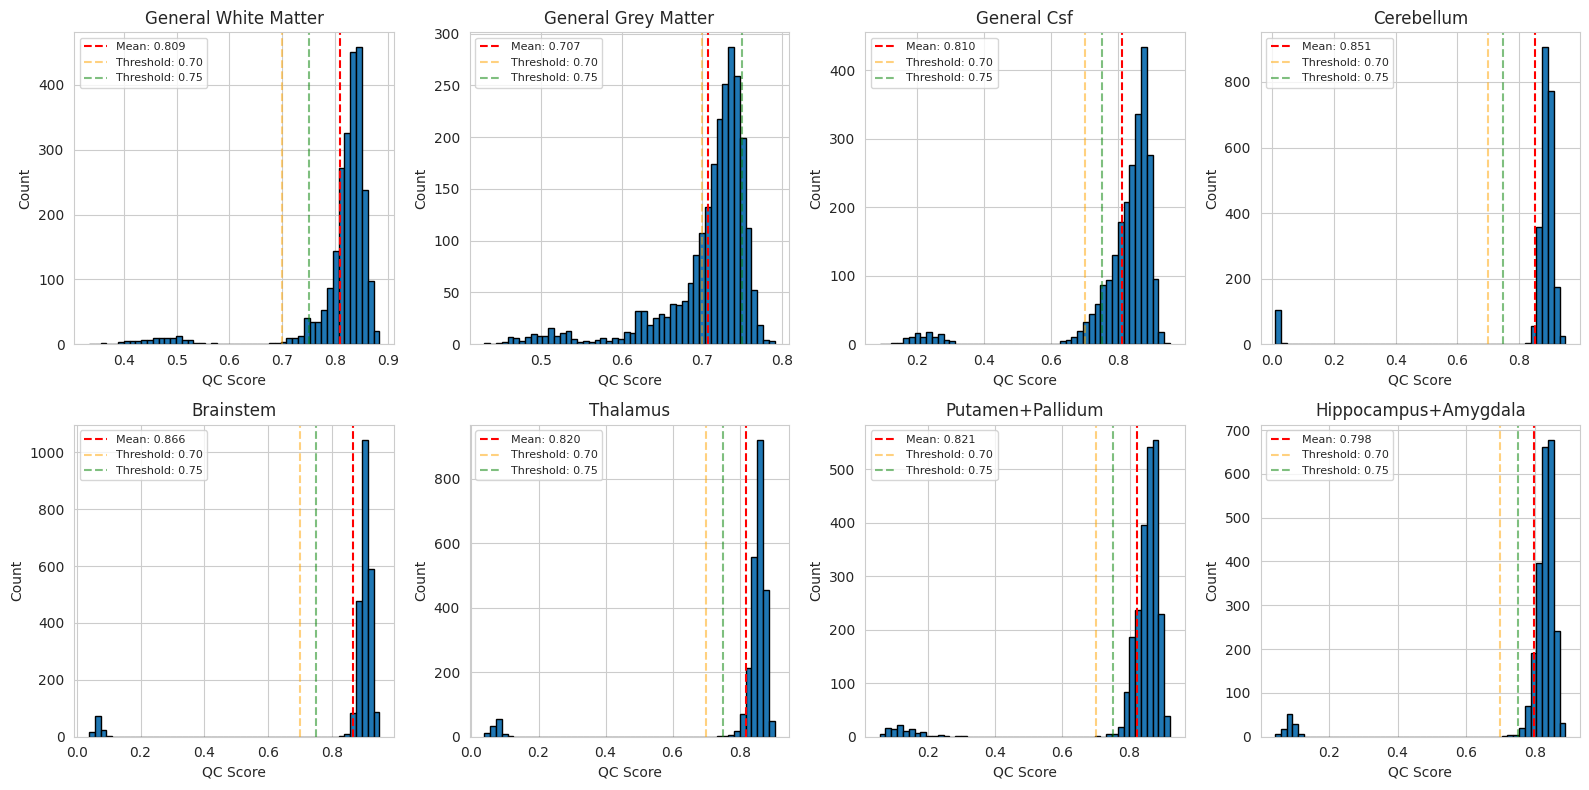

In [ ]:
# QC scores distribution
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i, qc_col in enumerate(qc_cols):
    ax = axes[i]
    df[qc_col].hist(bins=50, ax=ax, edgecolor='black')
    ax.axvline(df[qc_col].mean(), color='red', linestyle='--', label=f'Mean: {df[qc_col].mean():.3f}')
    ax.axvline(0.70, color='orange', linestyle='--', alpha=0.5, label='Threshold: 0.70')
    ax.axvline(0.75, color='green', linestyle='--', alpha=0.5, label='Threshold: 0.75')
    ax.set_xlabel('QC Score')
    ax.set_ylabel('Count')
    ax.set_title(qc_col.replace('qc_', '').replace('_', ' ').title())
    ax.legend(fontsize=8)

plt.tight_layout()
# plt.savefig('figures/qc_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

In [6]:
# QC statistics by dataset
qc_summary = df.groupby('dataset')[qc_cols].agg(['mean', 'min', 'max'])
print("\nQC scores by dataset:")
print(qc_summary)


QC scores by dataset:
        qc_general white matter                 qc_general grey matter  \
                           mean     min     max                   mean   
dataset                                                                  
ADNI                   0.828343  0.6758  0.8834               0.716150   
IXI                    0.828082  0.7380  0.8754               0.718701   
OASIS2                 0.837425  0.7707  0.8679               0.730471   
OASIS3                 0.780642  0.3343  0.8799               0.691806   
PPMI                   0.819741  0.6545  0.8674               0.702951   
SRPBS                  0.828563  0.7271  0.8768               0.722337   

                        qc_general csf                 qc_cerebellum  ...  \
            min     max           mean     min     max          mean  ...   
dataset                                                               ...   
ADNI     0.5182  0.7680       0.856548  0.6887  0.9429      0.892803  ...   
IX

In [8]:
# Apply QC filters
# Moderate thresholds: grey matter ≥ 0.70, others ≥ 0.75
qc_thresholds = {
    'qc_hippocampus+amygdala': 0.75,
}

df_filtered = df.copy()
n_before = len(df_filtered)

print("Applying QC filters...")
for qc_col, threshold in qc_thresholds.items():
    if qc_col in df_filtered.columns:
        n_removed = (df_filtered[qc_col] < threshold).sum()
        df_filtered = df_filtered[df_filtered[qc_col] >= threshold]
        print(f"  {qc_col} >= {threshold}: removed {n_removed} subjects")

n_after = len(df_filtered)
print(f"\n✓ Subjects after QC: {n_after}/{n_before} ({n_after/n_before*100:.1f}%)")
print(f"✓ Removed: {n_before - n_after} subjects ({(n_before-n_after)/n_before*100:.1f}%)")

Applying QC filters...
  qc_hippocampus+amygdala >= 0.75: removed 116 subjects

✓ Subjects after QC: 2289/2405 (95.2%)
✓ Removed: 116 subjects (4.8%)


In [9]:
# Dataset distribution after QC
print("\nDataset distribution after QC:")
print(df_filtered['dataset'].value_counts())

# Demographics after QC
print(f"\nAge: {df_filtered['age'].mean():.1f} ± {df_filtered['age'].std():.1f} years")
print(f"Range: {df_filtered['age'].min():.1f} - {df_filtered['age'].max():.1f} years")
print(f"\nSex distribution:")
print(df_filtered['sex'].value_counts())


Dataset distribution after QC:
dataset
OASIS3    846
ADNI      518
IXI       430
SRPBS     251
PPMI      159
OASIS2     85
Name: count, dtype: int64

Age: 67.6 ± 9.4 years
Range: 45.0 - 95.0 years

Sex distribution:
sex
F    1300
M     989
Name: count, dtype: int64


## 3. Calculate Derived Metrics

In [10]:
# 3.1 Total volumes for bilateral structures
print("Calculating total volumes for bilateral structures...")

bilateral_structures = [
    'hippocampus',
    'lateral ventricle'
]

for structure in bilateral_structures:
    left_col = f'vol_left {structure}'
    right_col = f'vol_right {structure}'
    
    if left_col in df_filtered.columns and right_col in df_filtered.columns:
        total_col = f'vol_total_{structure.replace(" ", "_")}'
        df_filtered[total_col] = df_filtered[left_col] + df_filtered[right_col]
        print(f"  ✓ {total_col}")

Calculating total volumes for bilateral structures...
  ✓ vol_total_hippocampus
  ✓ vol_total_lateral_ventricle


In [11]:
# 3.2 Normalized volumes (by TIV)
print("\nCalculating normalized volumes (by TIV)...")

tiv_col = 'vol_total intracranial'
if tiv_col in df_filtered.columns:
    regions_to_normalize = [
        'vol_total_hippocampus',
        'vol_total_lateral_ventricle',
    ]
    
    for vol_col in regions_to_normalize:
        if vol_col in df_filtered.columns:
            norm_col = vol_col + '_norm'
            df_filtered[norm_col] = df_filtered[vol_col] / df_filtered[tiv_col]
            print(f"  ✓ {norm_col}")


Calculating normalized volumes (by TIV)...
  ✓ vol_total_hippocampus_norm
  ✓ vol_total_lateral_ventricle_norm


In [12]:
# 3.3 Asymmetry indices
print("\nCalculating asymmetry indices...")

structures_for_asymmetry = [
    'hippocampus',
]

for structure in structures_for_asymmetry:
    left_col = f'vol_left {structure}'
    right_col = f'vol_right {structure}'
    
    if left_col in df_filtered.columns and right_col in df_filtered.columns:
        asym_col = f'asym_{structure}'
        # Asymmetry index = |L - R| / (L + R)
        df_filtered[asym_col] = np.abs(df_filtered[left_col] - df_filtered[right_col]) / \
                                (df_filtered[left_col] + df_filtered[right_col])
        print(f"  ✓ {asym_col}")


Calculating asymmetry indices...
  ✓ asym_hippocampus


In [13]:
# 3.4 Brain parenchymal fraction
print("\nCalculating brain parenchymal fraction...")

if 'vol_total intracranial' in df_filtered.columns and 'vol_csf' in df_filtered.columns:
    ventricle_cols = [
        'vol_total_lateral_ventricle',
        'vol_3rd ventricle',
        'vol_4th ventricle'
    ]
    
    # Total ventricular volume
    ventricle_sum = df_filtered[[c for c in ventricle_cols if c in df_filtered.columns]].sum(axis=1)
    df_filtered['vol_total_ventricles'] = ventricle_sum
    
    # Brain parenchymal fraction = (TIV - ventricles - CSF) / TIV
    df_filtered['brain_parenchymal_fraction'] = (
        df_filtered['vol_total intracranial'] - 
        df_filtered['vol_total_ventricles'] - 
        df_filtered['vol_csf']
    ) / df_filtered['vol_total intracranial']
    
    print("  ✓ brain_parenchymal_fraction")
    print("  ✓ vol_total_ventricles")


Calculating brain parenchymal fraction...
  ✓ brain_parenchymal_fraction
  ✓ vol_total_ventricles


In [15]:
# Show new columns created
new_cols = [col for col in df_filtered.columns if col not in df.columns]
print(f"\n✓ Created {len(new_cols)} derived metrics:")
for col in new_cols:
    print(f"  - {col}")


✓ Created 7 derived metrics:
  - vol_total_hippocampus
  - vol_total_lateral_ventricle
  - vol_total_hippocampus_norm
  - vol_total_lateral_ventricle_norm
  - asym_hippocampus
  - vol_total_ventricles
  - brain_parenchymal_fraction


## 4. Exploratory Data Analysis

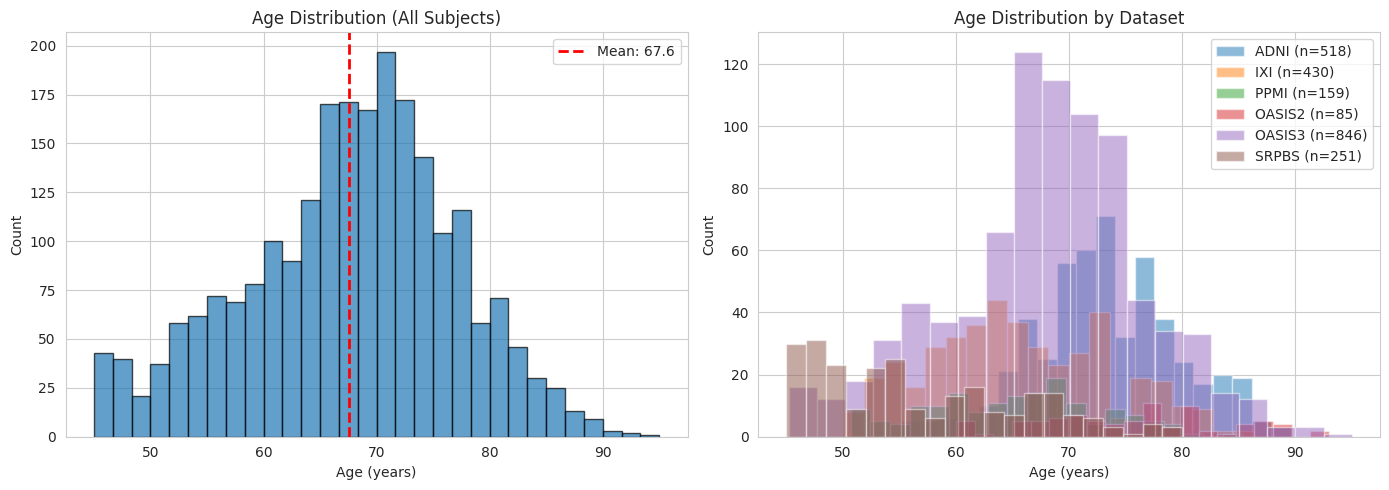

In [ ]:
# 4.1 Age distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Overall age distribution
ax = axes[0]
df_filtered['age'].hist(bins=30, ax=ax, edgecolor='black', alpha=0.7)
ax.axvline(df_filtered['age'].mean(), color='red', linestyle='--', linewidth=2, label=f"Mean: {df_filtered['age'].mean():.1f}")
ax.set_xlabel('Age (years)')
ax.set_ylabel('Count')
ax.set_title('Age Distribution (All Subjects)')
ax.legend()

# Age distribution by dataset
ax = axes[1]
for dataset in df_filtered['dataset'].unique():
    subset = df_filtered[df_filtered['dataset'] == dataset]
    ax.hist(subset['age'], bins=20, alpha=0.5, label=f"{dataset} (n={len(subset)})")
ax.set_xlabel('Age (years)')
ax.set_ylabel('Count')
ax.set_title('Age Distribution by Dataset')
ax.legend()

plt.tight_layout()
# plt.savefig('figures/age_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

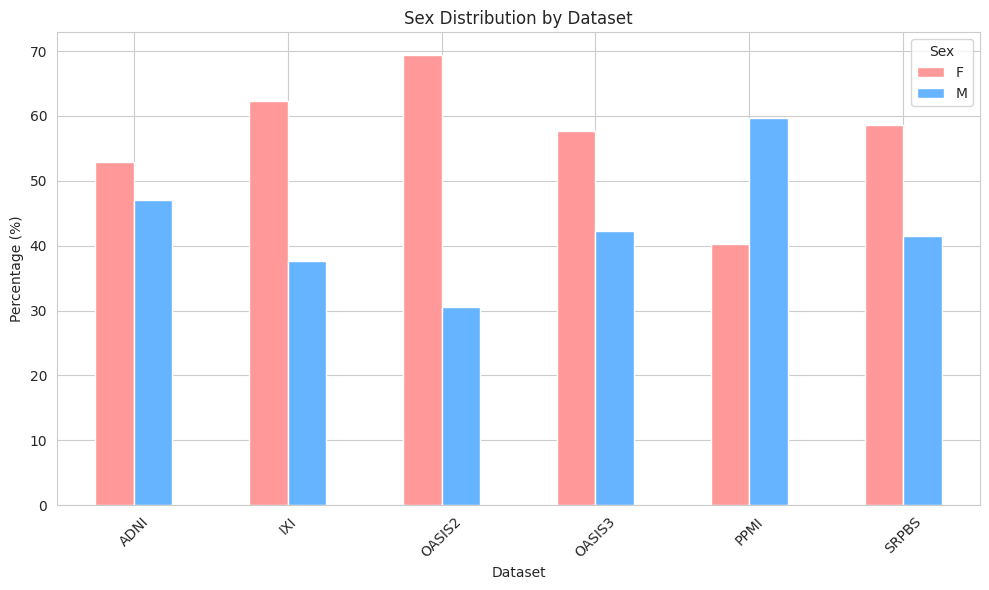


Sex distribution by dataset (counts):
sex        F    M
dataset          
ADNI     274  244
IXI      268  162
OASIS2    59   26
OASIS3   488  358
PPMI      64   95
SRPBS    147  104


In [ ]:
# 4.2 Sex distribution by dataset
sex_by_dataset = pd.crosstab(df_filtered['dataset'], df_filtered['sex'], normalize='index') * 100

fig, ax = plt.subplots(figsize=(10, 6))
sex_by_dataset.plot(kind='bar', ax=ax, color=['#ff9999', '#66b3ff'])
ax.set_xlabel('Dataset')
ax.set_ylabel('Percentage (%)')
ax.set_title('Sex Distribution by Dataset')
ax.legend(title='Sex')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.tight_layout()
# plt.savefig('figures/sex_distribution_by_dataset.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nSex distribution by dataset (counts):")
print(pd.crosstab(df_filtered['dataset'], df_filtered['sex']))

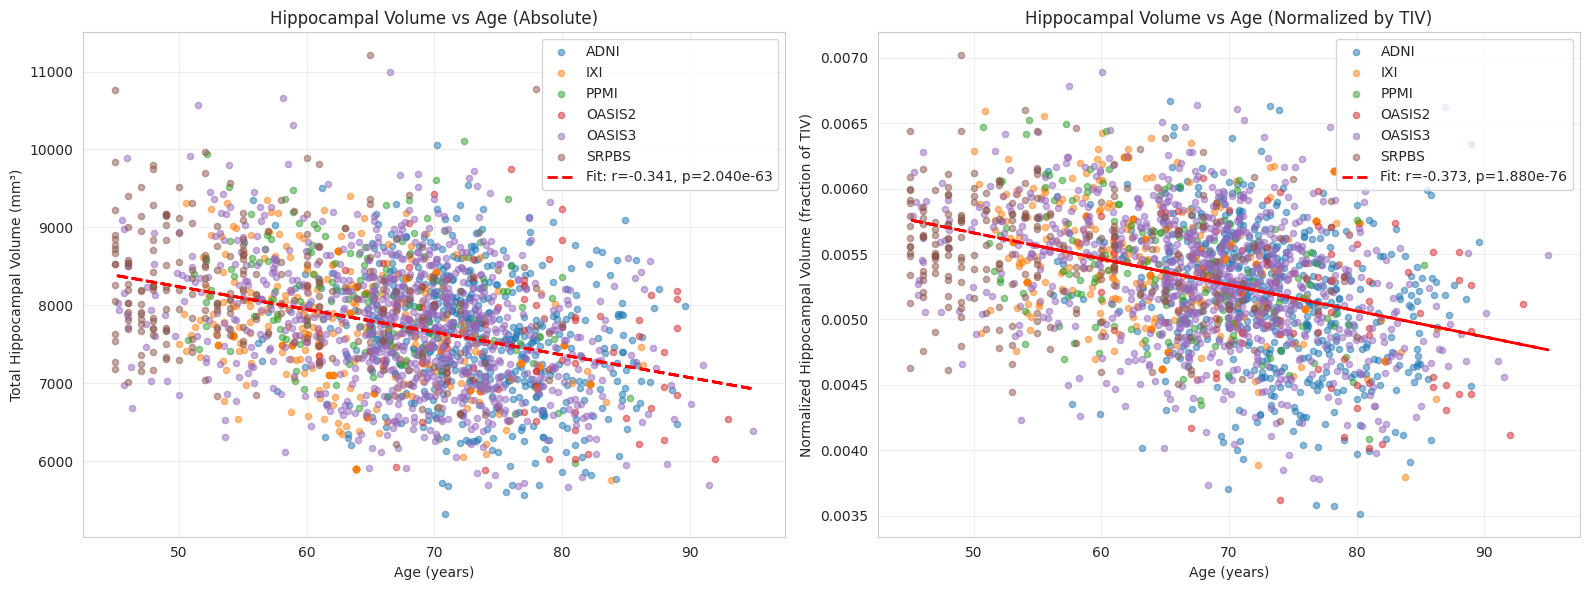

In [20]:
# 4.3 Hippocampal volume vs Age
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Absolute volume
ax = axes[0]
for dataset in df_filtered['dataset'].unique():
    subset = df_filtered[df_filtered['dataset'] == dataset]
    ax.scatter(subset['age'], subset['vol_total_hippocampus'], alpha=0.5, label=dataset, s=20)

# Add regression line
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(df_filtered['age'], df_filtered['vol_total_hippocampus'])
line = slope * df_filtered['age'] + intercept
ax.plot(df_filtered['age'], line, 'r--', linewidth=2, label=f'Fit: r={r_value:.3f}, p={p_value:.3e}')

ax.set_xlabel('Age (years)')
ax.set_ylabel('Total Hippocampal Volume (mm³)')
ax.set_title('Hippocampal Volume vs Age (Absolute)')
ax.legend()
ax.grid(True, alpha=0.3)

# Normalized volume
ax = axes[1]
for dataset in df_filtered['dataset'].unique():
    subset = df_filtered[df_filtered['dataset'] == dataset]
    ax.scatter(subset['age'], subset['vol_total_hippocampus_norm'], alpha=0.5, label=dataset, s=20)

# Add regression line
slope, intercept, r_value, p_value, std_err = linregress(df_filtered['age'], df_filtered['vol_total_hippocampus_norm'])
line = slope * df_filtered['age'] + intercept
ax.plot(df_filtered['age'], line, 'r--', linewidth=2, label=f'Fit: r={r_value:.3f}, p={p_value:.3e}')

ax.set_xlabel('Age (years)')
ax.set_ylabel('Normalized Hippocampal Volume (fraction of TIV)')
ax.set_title('Hippocampal Volume vs Age (Normalized by TIV)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../figures/hippocampus_vs_age.png', dpi=300, bbox_inches='tight')
plt.show()

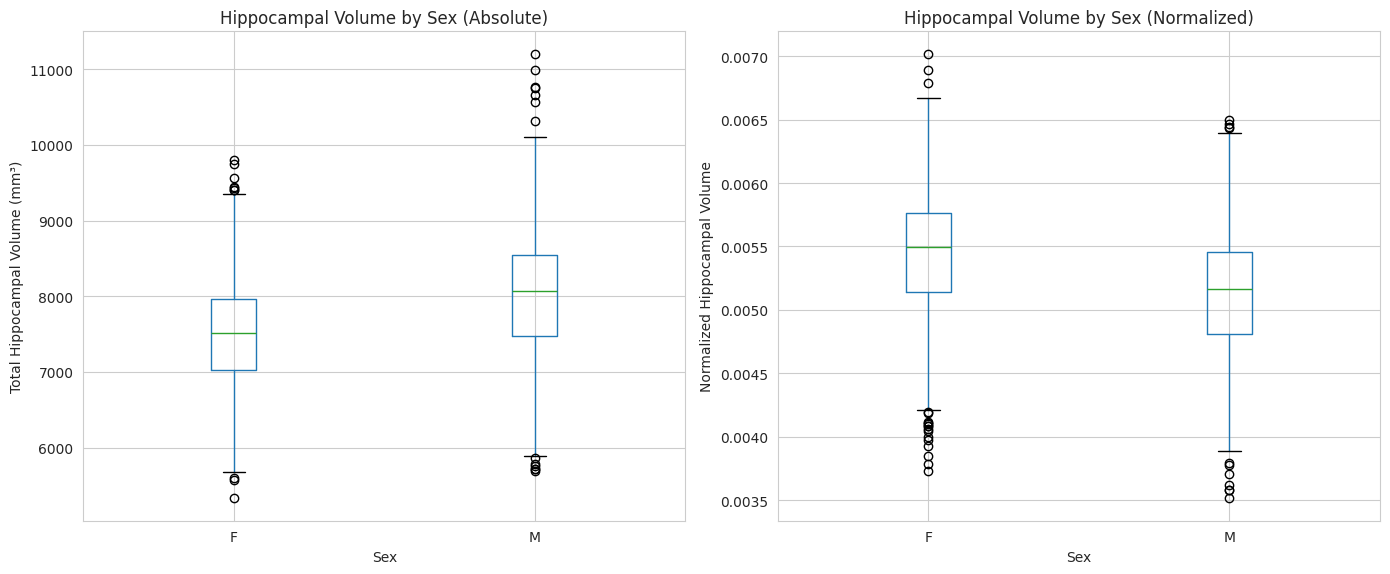


T-test for sex differences in normalized hippocampal volume:
  t-statistic: -15.9661
  p-value: 1.7336e-54
  Male mean: 0.005132
  Female mean: 0.005451


In [21]:
# 4.4 Sex differences in hippocampal volume
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Absolute volume
ax = axes[0]
df_filtered.boxplot(column='vol_total_hippocampus', by='sex', ax=ax)
ax.set_xlabel('Sex')
ax.set_ylabel('Total Hippocampal Volume (mm³)')
ax.set_title('Hippocampal Volume by Sex (Absolute)')
plt.suptitle('')

# Normalized volume
ax = axes[1]
df_filtered.boxplot(column='vol_total_hippocampus_norm', by='sex', ax=ax)
ax.set_xlabel('Sex')
ax.set_ylabel('Normalized Hippocampal Volume')
ax.set_title('Hippocampal Volume by Sex (Normalized)')
plt.suptitle('')

plt.tight_layout()
plt.savefig('../figures/hippocampus_by_sex.png', dpi=300, bbox_inches='tight')
plt.show()

# Statistical test
from scipy.stats import ttest_ind
male_hipp = df_filtered[df_filtered['sex'] == 'M']['vol_total_hippocampus_norm']
female_hipp = df_filtered[df_filtered['sex'] == 'F']['vol_total_hippocampus_norm']
t_stat, p_val = ttest_ind(male_hipp.dropna(), female_hipp.dropna())
print(f"\nT-test for sex differences in normalized hippocampal volume:")
print(f"  t-statistic: {t_stat:.4f}")
print(f"  p-value: {p_val:.4e}")
print(f"  Male mean: {male_hipp.mean():.6f}")
print(f"  Female mean: {female_hipp.mean():.6f}")

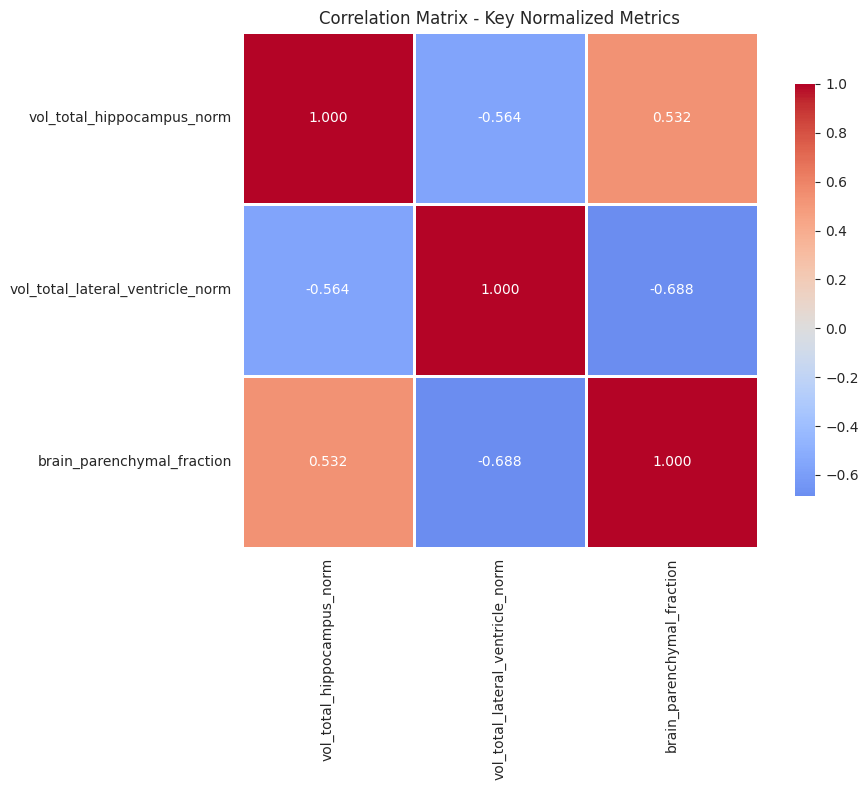

In [22]:
# 4.5 Correlation matrix for key regions
key_regions = [
    'vol_total_hippocampus_norm',
    'vol_total_amygdala_norm',
    'vol_total_lateral_ventricle_norm',
    'vol_brain-stem_norm',
    'brain_parenchymal_fraction',
    'grey_white_ratio'
]

key_regions = [col for col in key_regions if col in df_filtered.columns]

corr_matrix = df_filtered[key_regions].corr()

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=ax)
ax.set_title('Correlation Matrix - Key Normalized Metrics')
plt.tight_layout()
# plt.savefig('figures/correlation_matrix_key_regions.png', dpi=300, bbox_inches='tight')
plt.show()

## 5. Select Regions of Interest for Normative Modeling

In [23]:
# Define regions of interest for normative modeling
# Focus on regions relevant for AD/aging research

regions_of_interest = [
    # Demographics
    'subject_id',
    'dataset',
    'age',
    'sex',
    'site',
    
    
    # Subcortical structures (absolute)
    'vol_left hippocampus',
    'vol_right hippocampus',
    'vol_total_hippocampus',
    
    # Subcortical structures (normalized)
    'vol_total_hippocampus_norm',
    
    # Ventricles
    'vol_total_lateral_ventricle',
    'vol_total_lateral_ventricle_norm',
    'vol_total_ventricles',
    
    
    # Asymmetry indices
    'asym_hippocampus',
    
    
    # QC scores
    'qc_hippocampus+amygdala'
]

# Filter to columns that exist
regions_of_interest = [col for col in regions_of_interest if col in df_filtered.columns]

print(f"Selected {len(regions_of_interest)} columns for normative modeling")
print(f"\nColumns:")
for col in regions_of_interest:
    print(f"  - {col}")

Selected 14 columns for normative modeling

Columns:
  - subject_id
  - dataset
  - age
  - sex
  - site
  - vol_left hippocampus
  - vol_right hippocampus
  - vol_total_hippocampus
  - vol_total_hippocampus_norm
  - vol_total_lateral_ventricle
  - vol_total_lateral_ventricle_norm
  - vol_total_ventricles
  - asym_hippocampus
  - qc_hippocampus+amygdala


In [24]:
# Create final dataset for normative modeling
df_normative = df_filtered[regions_of_interest].copy()

print(f"\nFinal dataset shape: {df_normative.shape}")
print(f"Subjects: {len(df_normative)}")
print(f"Features: {len(regions_of_interest)}")

# Check for missing values
missing = df_normative.isnull().sum()
if missing.sum() > 0:
    print(f"\nMissing values:")
    print(missing[missing > 0])
else:
    print(f"\n✓ No missing values")


Final dataset shape: (2289, 14)
Subjects: 2289
Features: 14

Missing values:
site    518
dtype: int64


## 6. Save Final Dataset

In [25]:
# Save filtered dataset with all derived metrics
output_file_full = data_dir / 'combined' / 'healthy_controls_age45plus_filtered_with_derived_metrics.csv'
df_filtered.to_csv(output_file_full, index=False)
print(f"✓ Saved full filtered dataset: {output_file_full}")
print(f"  Shape: {df_filtered.shape}")

# Save normative modeling dataset (selected ROIs)
output_file_normative = data_dir / 'combined' / 'normative_modeling_dataset.csv'
df_normative.to_csv(output_file_normative, index=False)
print(f"\n✓ Saved normative modeling dataset: {output_file_normative}")
print(f"  Shape: {df_normative.shape}")

✓ Saved full filtered dataset: ../data/combined/healthy_controls_age45plus_filtered_with_derived_metrics.csv
  Shape: (2289, 127)

✓ Saved normative modeling dataset: ../data/combined/normative_modeling_dataset.csv
  Shape: (2289, 14)


## 7. Summary Statistics for Report

In [26]:
# Generate summary statistics
summary = pd.DataFrame({
    'Dataset': ['Total'],
    'N': [len(df_normative)],
    'Age (mean±SD)': [f"{df_normative['age'].mean():.1f}±{df_normative['age'].std():.1f}"],
    'Age (range)': [f"{df_normative['age'].min():.0f}-{df_normative['age'].max():.0f}"],
    'Female (%)': [f"{(df_normative['sex']=='F').sum()/len(df_normative)*100:.1f}"],
    'Male (%)': [f"{(df_normative['sex']=='M').sum()/len(df_normative)*100:.1f}"]
})

# Add per-dataset statistics
for dataset in sorted(df_normative['dataset'].unique()):
    subset = df_normative[df_normative['dataset'] == dataset]
    summary = pd.concat([summary, pd.DataFrame({
        'Dataset': [dataset],
        'N': [len(subset)],
        'Age (mean±SD)': [f"{subset['age'].mean():.1f}±{subset['age'].std():.1f}"],
        'Age (range)': [f"{subset['age'].min():.0f}-{subset['age'].max():.0f}"],
        'Female (%)': [f"{(subset['sex']=='F').sum()/len(subset)*100:.1f}"],
        'Male (%)': [f"{(subset['sex']=='M').sum()/len(subset)*100:.1f}"]
    })], ignore_index=True)

print("\n" + "="*80)
print("FINAL SUMMARY STATISTICS")
print("="*80)
print(summary.to_string(index=False))

# Save summary
summary.to_csv(data_dir / 'combined' / 'normative_dataset_summary.csv', index=False)
print(f"\n✓ Saved summary: {data_dir / 'combined' / 'normative_dataset_summary.csv'}")


FINAL SUMMARY STATISTICS
Dataset    N Age (mean±SD) Age (range) Female (%) Male (%)
  Total 2289      67.6±9.4       45-95       56.8     43.2
   ADNI  518      73.3±6.4       55-90       52.9     47.1
    IXI  430      65.6±7.9       50-86       62.3     37.7
 OASIS2   85      75.8±8.1       60-93       69.4     30.6
 OASIS3  846      67.9±8.6       45-95       57.7     42.3
   PPMI  159      65.2±7.4       51-85       40.3     59.7
  SRPBS  251      56.5±9.0       45-80       58.6     41.4

✓ Saved summary: ../data/combined/normative_dataset_summary.csv
